In [1]:
import torch
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from data.datasets import ADNIDataset

from torch.utils.data import DataLoader

#### Load experiment

In [8]:
# Experiment folder
exp_dir = './experiments/mynet_20250811_205600'

In [9]:
# Load config
cfg = OmegaConf.load(exp_dir + '/config.yaml')

In [10]:
# Load test dataset
test_dataset = ADNIDataset(cfg.data.test_csv)

In [11]:
# Load model
model = torch.load(exp_dir + '/fold_1/best_model.pth', map_location=torch.device('cpu'), weights_only=False)

#### Register hooks to store layer activations

In [12]:
# 1. Dictionary to store activations
activations = {}

# 2. Hook function
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu()
    return hook

# 3. Register hooks to all layers
for name, layer in model.named_modules():
    # Only register to layers with parameters (skip containers like nn.Sequential)
    if len(list(layer.children())) == 0:
        layer.register_forward_hook(get_activation(name))

#### View activations

In [13]:
sample_index = 0
img,lbl = test_dataset[sample_index]

In [14]:
loader = DataLoader(test_dataset,10)

batches = []
for imgs,lbls in loader:
    batches.append(imgs)
    
model.eval()
out = model(batches[0])


In [15]:
print(model)

MyNet(
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (mbn1): MaskedBatchNorm3d()
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock): ResidualBlock3D(
    (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (mbn1): MaskedBatchNorm3d()
    (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (mbn2): MaskedBatchNorm3d()
    (shortcut): Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  )
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv3d(32, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (mbn4): MaskedBatchNorm3d()
  (cbam_final): CBAM3D(
    (ca): ChannelAttention3D(
      (mlp): Sequential(
        (0): Linear(in_features=8, out_features=4, bias=False)
        (1): ReLU(inplace=True)
        (2

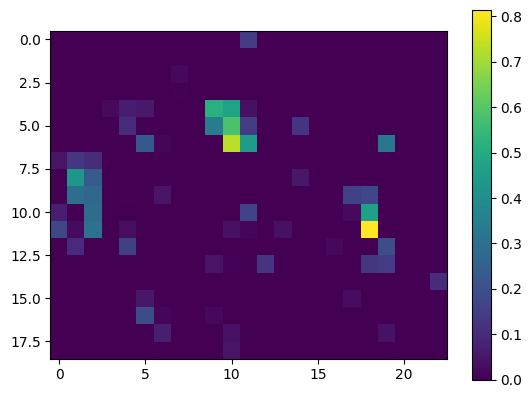

In [17]:
plt.imshow(torch.functional.F.relu(activations['mbn4'][0,7,:,:,10]))
plt.colorbar()

#### EigenCAM

In [18]:
from pytorch_grad_cam import GradCAM, EigenCAM, GradCAMPlusPlus, LayerCAM,ScoreCAM, ShapleyCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [19]:
target_layer_name = 'conv4'

In [20]:
target_layer = None
for name, module in model.named_modules():
    if name == target_layer_name:
        target_layer = module
        break

In [21]:
with EigenCAM(model=model, target_layers=[ target_layer ]) as cam:
       gcam_overlay = cam(batches[4], targets=[ ClassifierOutputTarget(0)])

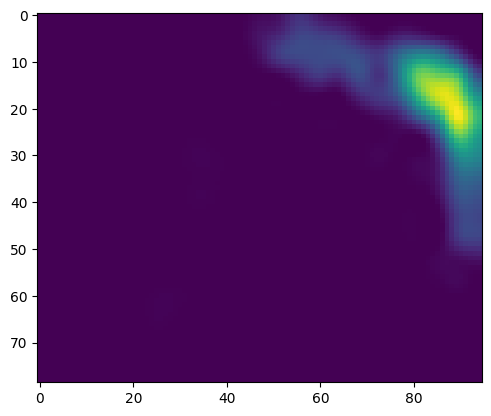

In [32]:
plt.imshow(gcam_overlay[9,:,:,35])